In [2]:
!pip install numpy==1.16.1
import numpy as np

In [4]:
!pip install openni
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
from PIL import Image
import itertools 
from sklearn.preprocessing import normalize
import os
from os.path import isfile, join
from scipy import ndimage, misc
from PIL import Image, ImageDraw
from scipy.signal import find_peaks
from openni import openni2
!git clone https://github.com/roccopietrini/pyOniExtractor.git
%cd pyOniExtractor
!cp -r /content/frame_extractor.py /content/pyOniExtractor/

fatal: destination path 'pyOniExtractor' already exists and is not an empty directory.
/content/pyOniExtractor


In [20]:
%rm -r pyOniExtractor

In [5]:
!python3 frame_extractor.py --v '/content/00-16-57.oni'

Depth Stream found
Depth frames: 369
All depth frames extracted
Done!


In [6]:
#Extract depth frames in order and append into depthFrame variable for use
%cd img
pathIn= "/content/pyOniExtractor/img/"
depthFrames = []
files =  os.listdir()
sorted_files =  sorted(files)
for i in range(len(sorted_files)):
    filename=pathIn + sorted_files[i]
    #reading each files
    img = cv2.imread(filename)
    img_single = img[:,:,0]
    depthFrames.append(img_single)
%cd ..
%cd ..

/content/pyOniExtractor/img
/content/pyOniExtractor
/content


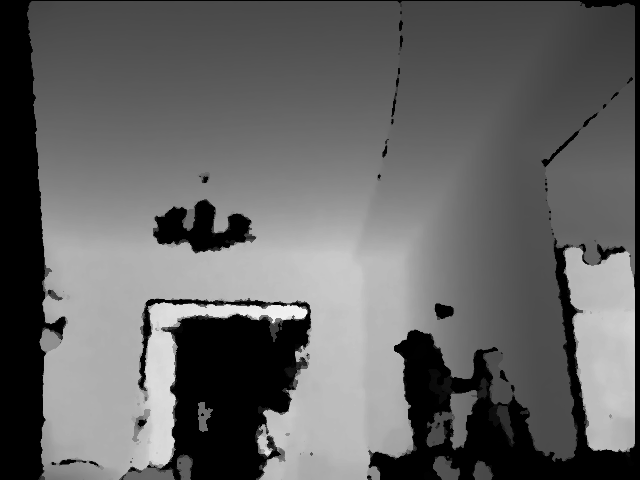

In [7]:
#Extract the first 30 frames from video
numOfFrames = int(len(depthFrames))
envDepthFrames = depthFrames[:20]
smoothedEnv = np.zeros(envDepthFrames[0].shape)
#Apply median filter to each frame and average all frames to get "smoothedEnv"
for i in range(len(envDepthFrames)):
    img = envDepthFrames[i].astype(np.float32)
    result = ndimage.median_filter(img, size=3)
    smoothedEnv = (smoothedEnv + result)/2
cv2_imshow(smoothedEnv)


**Test Depth Map face detection here**

[155 191 284 290 307 318 334 342]


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


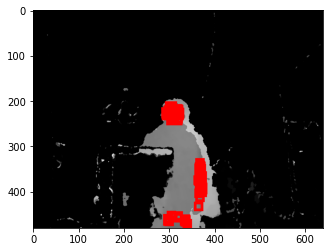

In [9]:
'''This part filters the depth frame and perform face detection
You can change the first line of code depthFrame index to observe the face detection 
at different frames. The index should be betwen 0-360 for the given test video'''
test = depthFrames[300]
test = ndimage.median_filter(test, size=3)
test = smoothedEnv-test
test = ndimage.median_filter(test, size=3)
test[test<0] = 0
#print(test[100:200,280:320])
#print(np.where(test[100:200,280:320]==np.max(test[100:200,280:320])))

image = Image.fromarray(test.astype('uint8')).convert('RGB')
image_draw = image.copy()
draw = ImageDraw.Draw(image_draw)
threshold = 0.9
R = 220
# fw = 2210
# fy = 2210
fw = 2800
fy = 2800
t_std = 3.783282046500663
t_ratio = 0.9535489709982228
boxes_D = []
p_std = []
p_ratio = []

shape = [(280,200), (350,100)] 
peaks, _ = find_peaks(test[:,359], height=70)
#print(peaks)
peaks1, _ = find_peaks(test[220,:], height=10)
print(peaks1)

#for i in range(len(peaks1)):
index = peaks1[4]
D = test[220,index]*255
w = R/D*fw
h = R/D*fy

# sum = np.sum(test[220-int(h/2):220+int(h/2),index-int(w/2):index+int(w/2)])
# std = np.std(test[220-int(h/2):220+int(h/2),index-int(w/2):index+int(w/2)])
# ave = sum/(h*w)
# ratio = ave/test[220,index]
# print(index,ratio,std)

#in each row and column, find the peaks
for r in range(test.shape[0]):
  peaks,_ = find_peaks(test[r,:], height = 20)
  for i in range(len(peaks)):
    index = peaks[i]
    #assign w, h and D by the method metioned in report
    D = test[r,index]*255
    w = R/D*fw
    h = R/D*fy
    #find sum and std for each window
    sum = np.sum(test[r-int(h/2):r+int(h/2),index-int(w/2):index+int(w/2)])
    std = np.std(test[r-int(h/2):r+int(h/2),index-int(w/2):index+int(w/2)])
    ave = sum/(h*w)
    ratio = ave/test[r,index]
    #limit the output window by filtering std, peak to area ratio and w,h
    if (ratio) > threshold and std < 20 and std > 1 and w >20 and h>20:
      draw.rectangle((index-int(w/2),(r-int(h/2)),(index+int(w/2),(r+int(h/2)))), outline=(255,0,0), width=6)
      p_1 = abs((std-t_std)/t_std)
      p_2 = abs((ratio-t_ratio)/t_ratio)
      p_std.append(p_1)
      p_ratio.append(p_2)
      boxes_D.append(np.array([index-int(w/2),r-int(h/2),index+int(w/2),r+int(h/2)]))
      # print(r,index,ratio,std)
for c in range(test.shape[1]):
  peaks,_ = find_peaks(test[:,c], height = 20)
  for i in range(len(peaks)):
    index = peaks[i]
    D = test[index,c]*255
    w = R/D*fw
    h = R/D*fy
    sum = np.sum(test[index-int(h/2):index+int(h/2),c-int(w/2):c+int(w/2)])
    std = np.std(test[index-int(h/2):index+int(h/2),c-int(w/2):c+int(w/2)])
    ave = sum/(h*w)
    ratio = ave/test[index,c]
    #limit the output window by filtering std, peak to area ratio and w,h
    if (ratio) > threshold and std < 20 and std > 1 and w >20 and h>20:
       draw.rectangle((c-int(w/2),(index-int(h/2)),(c+int(w/2),index+int(h/2))), outline=(255,0,0), width=6)
       p_1 = abs((std-t_std)/t_std)
       p_2 = abs((ratio-t_ratio)/t_ratio)
       #append the std and ratio into list for template matching
       p_std.append(p_1)
       p_ratio.append(p_2)
       boxes_D.append(np.array([c-int(w/2),index-int(h/2),c+int(w/2),index+int(h/2)]))

# print(D,w,h,fw,fy)
  # sum = np.sum(test[150-int(h/2):150+int(h/2),index-int(w/2):index+int(w/2)])
  # ave = sum/(h*w)
  # ratio = ave/test[150,index]
  # std = np.std(test[150-int(h/2):150+int(h/2),index-int(w/2):index+int(w/2)])
  #print(i,test[150][index],ratio,std)
#draw.rectangle(((275,180), (350,100)), outline=(255,0,0), width=6)

#calcualte z score for each windown std and ratio and use z score as weight to assign confidence
p_std = p_std/np.linalg.norm(p_std)
p_ratio = p_ratio/np.linalg.norm(p_ratio)
p = 1 - (p_std*5 + p_ratio*5)
p_arr = np.array(p)
boxes_arr = np.array(boxes_D)
boxes_d = np.zeros((boxes_arr.shape[0],5))
boxes_d[:,:4] = boxes_arr
boxes_d[:,-1] = p_arr
#print(max(p_std),max(p_ratio),p)
#print(boxes_d.shape)
array = np.asarray(image_draw)
plt.imshow(array)

In [11]:
import numpy as np
import torch
from numpy import asarray
from torch.autograd import Variable
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import math
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageDraw
from scipy import signal
import ncc
import cv2
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

from get_nets import PNet, RNet, ONet
from box_utils import nms, calibrate_box, get_image_boxes, convert_to_square, _preprocess,correct_bboxes
from visualization_utils import show_bboxes

In [12]:
# define the min face size we want to detect
min_face_size = 15.0  

# for probabilities thresholds
p_thresholds = [0.6, 0.7, 0.8]

# for NMS thresholds
nms_thresholds=[0.7, 0.7, 0.7]

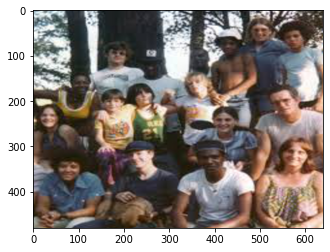

In [13]:
file = '/content/faces.jpeg'
image = Image.open(file)
image = image.resize((640,480))
plt.imshow(image)

In [14]:
#create image pyramids by scale and the minsize we want to detect faces
#My own work
def MakeGaussianPyramid(image, scale, minsize):
  """
  Arguments:
    image: an PIL.Image
    scale: a float number for each pyramid level scaling
    minsize: The min image size we shrink to, which is relevant to the min size
             of faces we want to detect
  Returns:
    a list of image pyramids 
  """
  img = Image.open(image)
  img = img.resize((640,480))
  img_array = asarray(img, dtype=np.float64)
  x = img_array.shape[1]
  y = img_array.shape[0]
  #minsize = 50 test
  #scale = 0.5 test
  #check how many shrinks do I need
  scale_factor = [1]
  count_x = math.floor(x/minsize)
  count_y = math.floor(y/minsize)
  if (count_x >= count_y):
    count = count_y
  else:
    count = count_x
  L = list([img_array])

  #make sure minsize is not bigger than one shrink
  assert (count != 0), "minsize is too big for the scale"
  if (img_array.ndim == 3):
    for i in range(count):
    #seperate into 3 channels and perform convolution with gaussian filter
      img_array_0 = L[i][:,:,0]
      array_after_0 = gaussian_filter(img_array_0,1/(2*scale))
      img_array_1 = L[i][:,:,1]
      array_after_1 = gaussian_filter(img_array_1,1/(2*scale))
      img_array_2 = L[i][:,:,2]
      array_after_2 = gaussian_filter(img_array_2,1/(2*scale))
      array_after = np.dstack((img_array_0,img_array_1,img_array_2))
      array_re = cv2.resize(array_after,((int(x*(scale)**(i+1)),int(y*(scale)**(i+1)))),interpolation=cv2.INTER_CUBIC)
      index = len(L)
      L.insert(index,array_re)  
      scale_factor.append((scale)**(i+1))
    #for gray scale image
    #gaussian filter first then resize and turn into image format again to add 
    #to the pyramid
  elif (img_array.ndim == 2):
    for i in range(count):
      array_after = gaussian_filter(L[i],1/(2*scale))
      array_re = cv2.resize(array_after,((int(x*(scale)**(i+1)),int(y*(scale)**(i+1)))),interpolation=cv2.INTER_CUBIC)
      #array_re = asarray(img_re)
      index = len(L)
      L.insert(index,array_re)
  print('scale factor:',['{:.2f}'.format(i) for i in scale_factor])
  return(L,scale_factor)

In [15]:
#show the crated image pyramid
#my own work
def ShowGaussianPyramid(pyramid):
  '''
  Arguments:
    A list of image pyramids 
  Returns:
    show the image pyrmaids in the horizontal direction
  '''
  img_array = pyramid
  length = len(pyramid)
  x = 0
  if (pyramid[0].ndim == 2):
    for i in range(length): 
      x += pyramid[i].shape[1]
    image = Image.new("L", (x, pyramid[0].shape[0]),'white')
    x_offset = 0
    for j in range(length):
      img1 = Image.fromarray(img_array[j])
      img_array_1 = img_array[j].copy()
      img_array_1 = img_array_1.astype('uint8')
      img1 = Image.fromarray(img_array_1)
      image.paste(img1,(x_offset,0))
      x_offset += img_array[j].shape[1]
    display(image)
  elif (pyramid[0].ndim == 3):
    for i in range(length): 
      x += pyramid[i].shape[1]
    image = Image.new("RGB", (x, pyramid[0].shape[0]),'white')
    x_offset = 0

    for j in range(length):
      img_array_A = img_array[j]
      img_array_B = img_array_A.astype('uint8')
      img_array_B = np.clip(img_array_B, 0, 255)
      img1 = Image.fromarray(img_array_B)
      #x_offset += img_array[0].shape[1]
      image.paste(img1,(x_offset,0))
      x_offset += img_array[j].shape[1]
    display(image)

scale factor: ['1.00', '0.75', '0.56', '0.42', '0.32', '0.24', '0.18', '0.13', '0.10', '0.08']


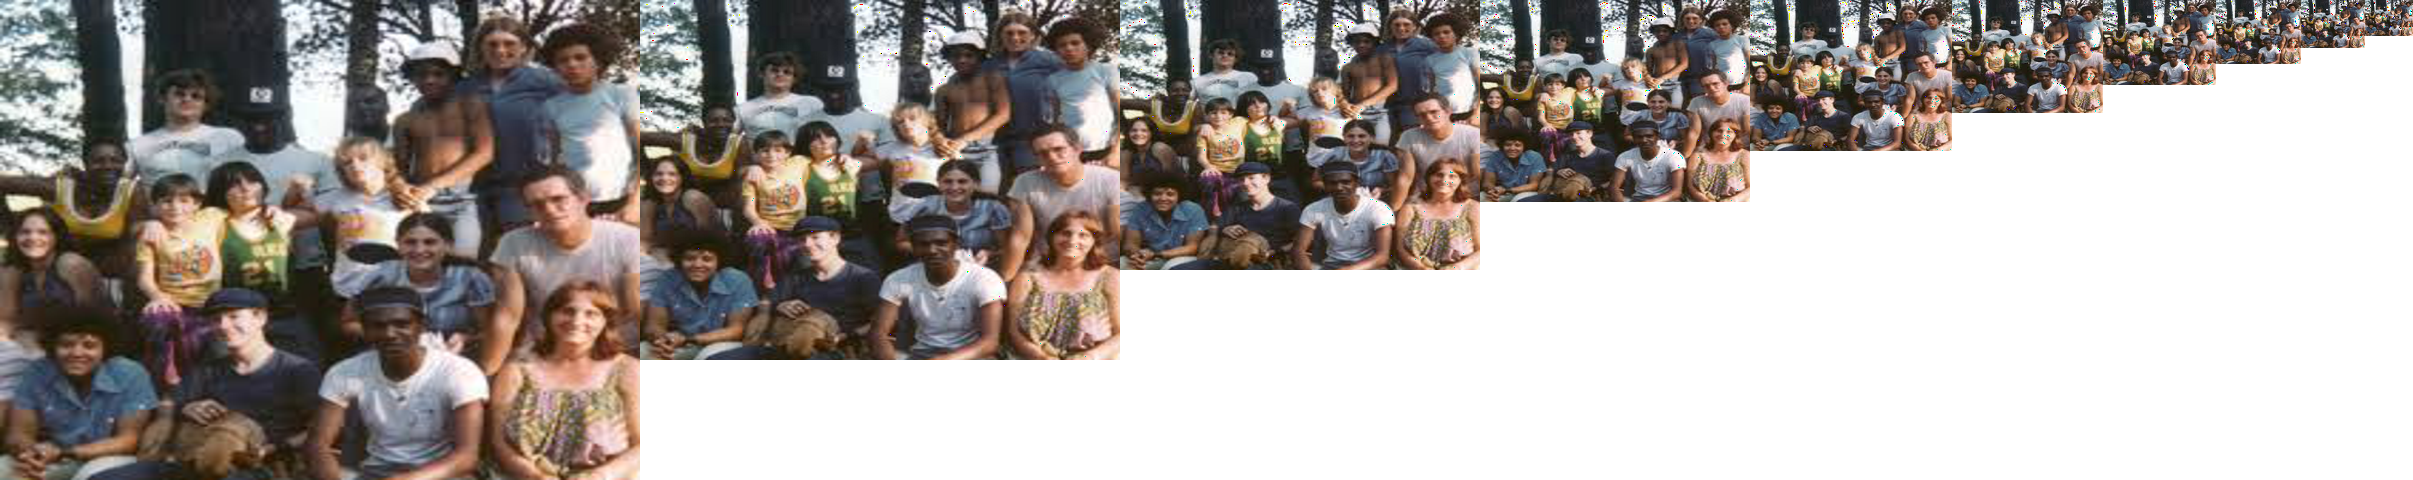

In [16]:
# change the ratio or the min size for testing
pyramid,scale_factor = MakeGaussianPyramid(file, 0.75, 50)
ShowGaussianPyramid(pyramid)

In [17]:
'''Followed "Joint face Detection and Alignment using multi-task Cscaded Convolutional 
Networks" Structure and tutorial from 
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
Due to the training limitation, used 'pnet.npy' weights from 
https://github.com/TropComplique/mtcnn-pytorch 
'''
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):

        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)

class PNet(nn.Module):

    def __init__(self):

        super(PNet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 10, 3, 1)),
            ('prelu1', nn.PReLU(10)),
            ('pool1', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(10, 16, 3, 1)),
            ('prelu2', nn.PReLU(16)),

            ('conv3', nn.Conv2d(16, 32, 3, 1)),
            ('prelu3', nn.PReLU(32))
        ]))

        self.conv4_1 = nn.Conv2d(32, 2, 1, 1)
        self.conv4_2 = nn.Conv2d(32, 4, 1, 1)

        weights = np.load('pnet.npy')[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
      
        x = self.features(x)
        tensor_a = self.conv4_1(x)
        tensor_b = self.conv4_2(x)
        tensor_a = F.softmax(tensor_a)
        return tensor_b, tensor_a

class RNet(nn.Module):

    def __init__(self):

        super(RNet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 28, 3, 1)),
            ('prelu1', nn.PReLU(28)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(28, 48, 3, 1)),
            ('prelu2', nn.PReLU(48)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(48, 64, 2, 1)),
            ('prelu3', nn.PReLU(64)),

            ('flatten', Flatten()),
            ('conv4', nn.Linear(576, 128)),
            ('prelu4', nn.PReLU(128))
        ]))

        self.conv5_1 = nn.Linear(128, 2)
        self.conv5_2 = nn.Linear(128, 4)

        weights = np.load('rnet.npy')[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
       
        x = self.features(x)
        tensor_a = self.conv5_1(x)
        tensor_b = self.conv5_2(x)
        tensor_a = F.softmax(tensor_a)
        return tensor_b, tensor_a


class ONet(nn.Module):

    def __init__(self):

        super(ONet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 2, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1152, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        self.conv6_1 = nn.Linear(256, 2)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)

        weights = np.load('onet.npy')[()]
        for n, p in self.named_parameters():
            p.data = torch.FloatTensor(weights[n])

    def forward(self, x):
       
        x = self.features(x)
        tensor_a = self.conv6_1(x)
        tensor_b = self.conv6_2(x)
        tensor_c = self.conv6_3(x)
        tensor_a = F.softmax(tensor_a)
        return tensor_c, tensor_b, tensor_a

In [18]:
'''
Developed by following github https://github.com/TropComplique/mtcnn-pytorch/blob/master/try_mtcnn_step_by_step.ipynb
Integrated with depth input from my own development and tuned parameters used and the overall flow of three stages
'''
def Run_P_Net(pyramid,p_thresholds):
  '''
  Arguments:
    pyramids: A list of image pyramids
    p_thresholds: threshold used for filtering faces after p net prediction
    note that this is a [3,] vector defined previously
  Returns:
    boxes of size (n,5) with 4 box positions and probability 
  '''
  net = PNet()
  boxes = []
  for i in range(len(pyramid)):
    img = pyramid[i]
    #preprocess img and convert to floatTensor format, run though P net to get 
    #probabilities and offsets
    img = Variable(torch.FloatTensor(_preprocess(img)), volatile=True)
    out = net(img)
    probs = out[1].data.numpy()[0, 1, :, :]
    offsets = out[0].data.numpy()
    
    stride = 2
    cell= 15
    # indices of boxes where there is probably a face
    index = np.where(probs > p_thresholds[0])

    # extract parameters from offsets for bounding boxes
    tx1, ty1, tx2, ty2 = [offsets[0, j, index[0], index[1]] for j in range(4)]
    # w = x2 - x1 + 1,h = y2 - y1 + 1,x1 = x1 + tx1*w,x2 = x2 + tx2*w,y1 = y1 + ty1*h,y2 = y2 + ty2*h
    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[index[0], index[1]]

    # P-Net is applied to scaled images
    # rescale bounding boxes back
    bounding_boxes = np.vstack([
        np.round((stride*index[1] + 1.0)/scale_factor[i]),
        np.round((stride*index[0] + 1.0)/scale_factor[i]),
        np.round((stride*index[1] + 1.0 + cell)/scale_factor[i]),
        np.round((stride*index[0] + 1.0 + cell)/scale_factor[i]),
        score, offsets])
    bounding_boxes = bounding_boxes.T
    #perform nms to merge overlapping boxes
    index1 = nms(bounding_boxes[:, 0:5], overlap_threshold = 0.5)
    boxes.append(bounding_boxes[index1])
  boxes = [i for i in boxes if i is not None]
  boxes = np.vstack(boxes)
  #calibration performed by using offsets predicted from pnet
  boxes = calibrate_box(boxes[:, 0:5], boxes[:, 5:])
  #convert boxes to square
  boxes = convert_to_square(boxes)
  boxes[:, 0:4] = np.round(boxes[:, 0:4])
  print('After P net, number of bounding boxes:', len(boxes))
  return boxes

def Run_R_Net(image,boxes,p_thresholds,nms_thresholds):
  '''
  Arguments:
    image: original image
    boxes: output boxes from the P net (n,5) shape
    p_thresholds: threshold used for filtering faces after n net prediction
    note that this is a [3,] vector defined previously
    nms_thresholds: threshold used for filtering faces after n net prediction
    note that this is a [3,] vector defined previously
  Returns:
    boxes: boudning boxes of size (n,5) with 4 box positions and probability
  '''
  net = RNet()
  boxes_R = get_image_boxes(boxes, image, size=24)

  #convert to floatTensor format, run though R net to get 
  #probabilities and offsets
  boxes_R = Variable(torch.FloatTensor(boxes_R), volatile=True)
  out = net(boxes_R)
  probs = out[1].data.numpy()
  offsets = out[0].data.numpy()
  # indices of boxes where there is probably a face
  index = np.where(probs[:, 1] > p_thresholds[1])[0]
  boxes = boxes[index]
  boxes[:, 4] = probs[index, 1].reshape((-1,))
  offsets = offsets[index]
  #NMS and calibration
  index1 = nms(boxes, nms_thresholds[1])
  boxes = boxes[index1]
  boxes = calibrate_box(boxes, offsets[index1])
  boxes = convert_to_square(boxes)
  boxes[:, 0:4] = np.round(boxes[:, 0:4])
  print('After R net, number of bounding boxes:', len(boxes))
  return boxes
  
def Run_O_Net(image,boxes,p_thresholds,nms_thresholds):
  '''
  Arguments:
    image: original image
    boxes: output boxes from the P net (n,5) shape
    p_thresholds: threshold used for filtering faces after n net prediction
    note that this is a [3,] vector defined previously
    nms_thresholds: threshold used for filtering faces after n net prediction
    note that this is a [3,] vector defined previously
  Returns:
    boxes: boudning boxes of size (n,5) with 4 box positions and probability
    landmarks: facial landmarks of size (n,10) 
  '''
  net = ONet()
  boxes_O = get_image_boxes(boxes, image, size=48)
  boxes_O = Variable(torch.FloatTensor(boxes_O), volatile=True)
  out = net(boxes_O)
  landmarks = out[0].data.numpy()  # shape [n_boxes, 10]
  offsets = out[1].data.numpy()  # shape [n_boxes, 4]
  probs = out[2].data.numpy()  # shape [n_boxes, 2]
  #indices of boxes where there is probably a face. In addtional to P,R , O net
  #outputs facial landmarks
  index = np.where(probs[:, 1] > p_thresholds[2])[0]
  boxes = boxes[index]
  boxes[:, 4] = probs[index, 1].reshape((-1,))
  offsets = offsets[index]
  landmarks = landmarks[index]
  #Extract landmark information based on boxes size
  w = boxes[:, 2] - boxes[:, 0] + 1.0
  h = boxes[:, 3] - boxes[:, 1] + 1.0
  xmin, ymin = boxes[:, 0], boxes[:, 1]
  landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(w, 1)*landmarks[:, 0:5]
  landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(h, 1)*landmarks[:, 5:10]
  #NMS and calibration
  boxes = calibrate_box(boxes, offsets)
  index1 = nms(boxes, nms_thresholds[2], mode='min')
  boxes = boxes[index1]
  landmarks = landmarks[index1]
  print('After O net, number of bounding boxes:', len(boxes))
  return boxes, landmarks

scale factor: ['1.00', '0.75', '0.56', '0.42', '0.32', '0.24', '0.18', '0.13', '0.10', '0.08']


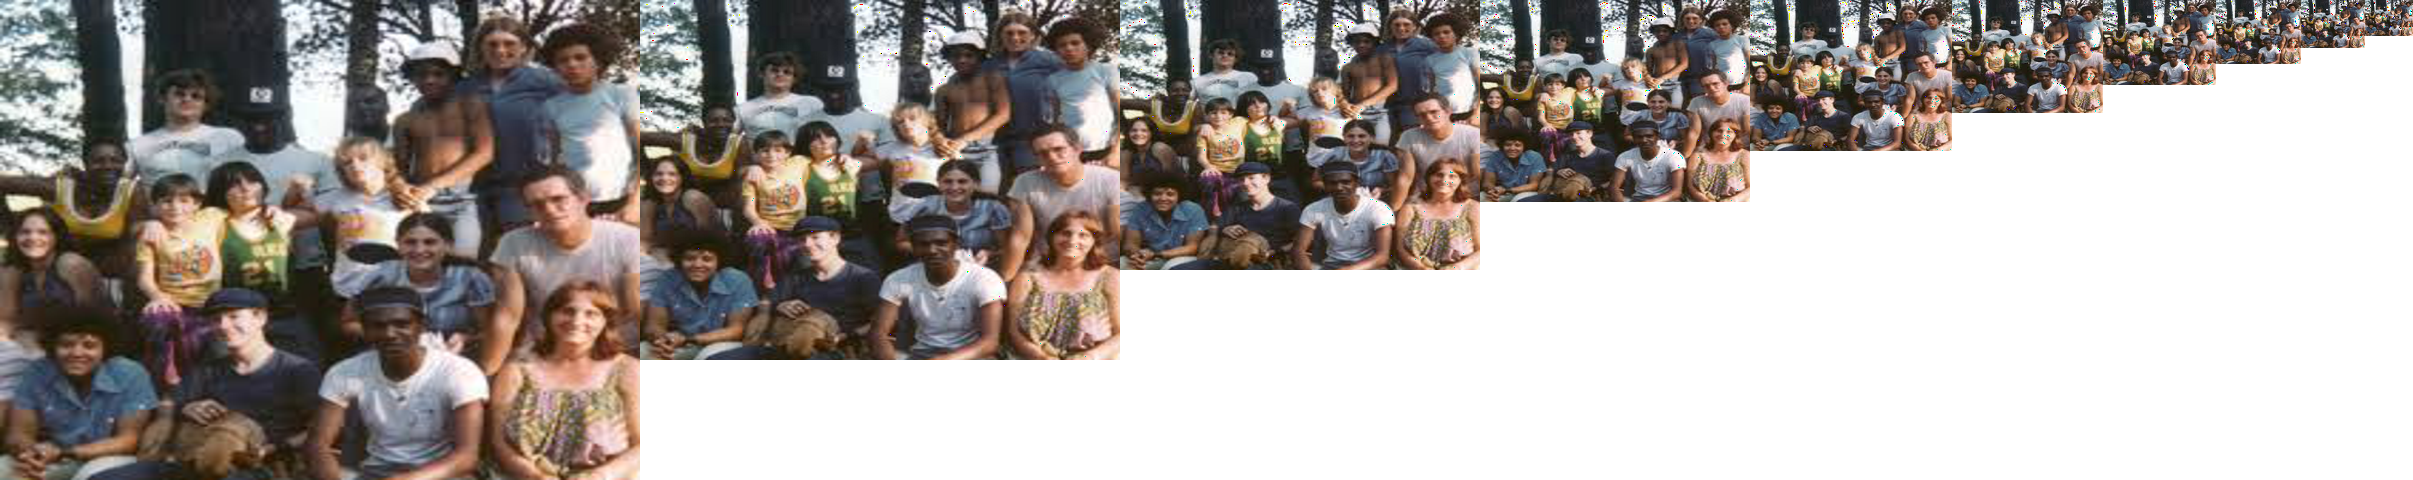

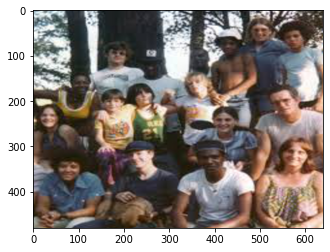

In [19]:
file = '/content/faces.jpeg'
image = Image.open(file)
image = image.resize((640,480))
plt.imshow(image)
pyramid,scale_factor = MakeGaussianPyramid(file, 0.75, 50)
ShowGaussianPyramid(pyramid)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


After P net, number of bounding boxes: 1316


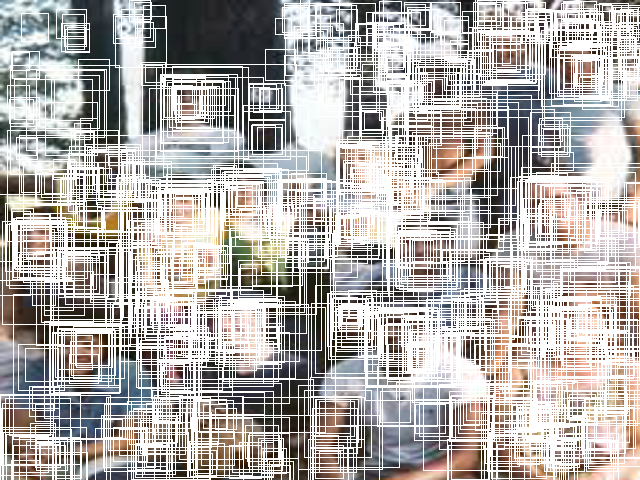

In [20]:
'''since depth map detection causes improper size of windows, we dont include boes_d
into MTCNN anymore. It causes the R-net return 0 bounding boxes so the network fails.
But you can still follow the P,R,O network below'''
boxes_P = Run_P_Net(pyramid,p_thresholds)
#boxes_PD = np.append(boxes_P,boxes_d)
show_bboxes(image, boxes_P)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


After R net, number of bounding boxes: 140


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


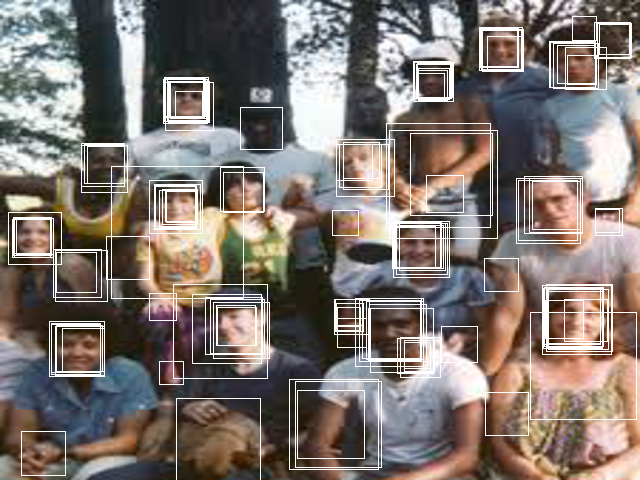

In [21]:
boxes_R = Run_R_Net(image,boxes_P,p_thresholds,nms_thresholds)
show_bboxes(image, boxes_R)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


After O net, number of bounding boxes: 15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


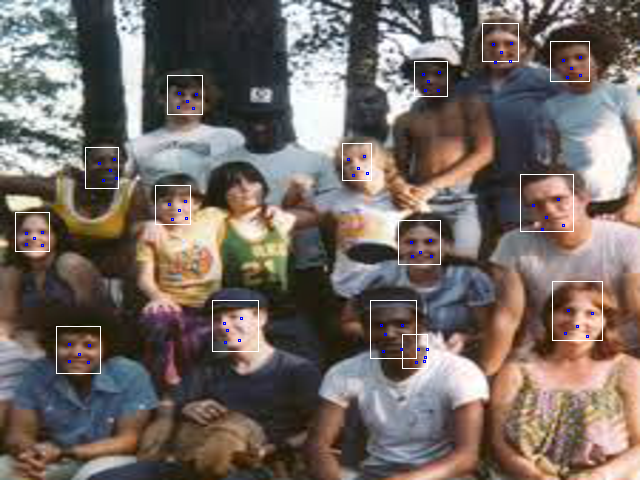

In [22]:
boxes_O,landmarks = Run_O_Net(image,boxes_R,p_thresholds,nms_thresholds)
show_bboxes(image, boxes_O, landmarks)

In [ ]:
!git clone https://github.com/timesler/facenet-pytorch.git
! pip install autocrop
! pip install split-folders
! pip install mmcv
!pip install facenet-pytorch
%cd facenet-pytorch

In [25]:

from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from models.inception_resnet_v1 import InceptionResnetV1
import cv2, mmcv
from PIL import Image, ImageDraw
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np
import splitfolders
from google.colab.patches import cv2_imshow
import random
import os
import shutil
import operator
from facenet_pytorch import MTCNN
from IPython import display
from keras.models import load_model
from keras.preprocessing import image

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [30]:
%cd test

/content/facenet-pytorch/data/test


In [29]:
%cd data
!mkdir train_data
!mkdir test
!mkdir sample
!mkdir test_me
%cd test

/content/facenet-pytorch/data


In [ ]:
#read frames from the 1st live video and putinto test folder 
vidcap = cv2.VideoCapture('/content/me.mov')
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite(f"{format(count, '04d')+'a'}.png", image)
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

path = '/content/facenet-pytorch/data/test'
files=os.listdir(path)
d=random.sample(files,100)

for i in d:
  shutil.copy(i,'/content/facenet-pytorch/data/sample')

! autocrop -i /content/facenet-pytorch/data/sample -o /content/facenet-pytorch/data/test_me/1 -r /content/facenet-pytorch/data/reject -w 224 -H 224 --facePercent 80

%cd ..
%rm -r test
%rm -r sample
!mkdir test
!mkdir sample
%cd test

In [ ]:
#read frames from the 2nd live video and putinto test folder 
vidcap = cv2.VideoCapture('/content/me1.mov')
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite(f"{format(count, '04d')+'b'}.png", image)
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

path = '/content/facenet-pytorch/data/test'
files=os.listdir(path)
d=random.sample(files,100)

for i in d:
  shutil.copy(i,'/content/facenet-pytorch/data/sample')

! autocrop -i /content/facenet-pytorch/data/sample -o /content/facenet-pytorch/data/test_me/2 -r /content/facenet-pytorch/data/reject -w 224 -H 224 --facePercent 80

%cd ..
%rm -r test
%rm -r sample
!mkdir test
!mkdir sample
%cd test

In [ ]:
#read frames from the 3rd live video and putinto test folder 
vidcap = cv2.VideoCapture('/content/me2.mov')
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite(f"{format(count, '04d')+'c'}.png", image)
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

path = '/content/facenet-pytorch/data/test'
files=os.listdir(path)
d=random.sample(files,100)

for i in d:
  shutil.copy(i,'/content/facenet-pytorch/data/sample')

! autocrop -i /content/facenet-pytorch/data/sample -o /content/facenet-pytorch/data/test_me/3 -r /content/facenet-pytorch/data/reject -w 224 -H 224 --facePercent 80

%cd ..
%rm -r test
%rm -r sample
!mkdir test
!mkdir sample
%cd test

In [ ]:
#split into training and test set
splitfolders.ratio("/content/facenet-pytorch/data/test_me", output="/content/facenet-pytorch/data/train_data", ratio=(.8, .2))

In [36]:
#data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.45, 0.45, 0.40], [0.23, 0.20, 0.22])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.45, 0.45, 0.40], [0.23, 0.20, 0.22])
    ]),
}
data_dir = '/content/facenet-pytorch/data/train_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['1', '2', '3']

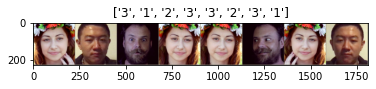

In [37]:
#show test images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
from keras.applications import vgg16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Loads the VGG16 model without the top or FC layers
model = vgg16.VGG16(weights='imagenet', include_top = False, input_shape=(img_rows,img_cols,3))

# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

In [ ]:
# Here we freeze the layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

def addTopModel(bottom_model, num_classes, D=256):
    #creates the top or head of the model that will be placed ontop of the bottom layers

    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Set the number of classes
num_classes = 3

FC_Head = addTopModel(model, num_classes)

modelnew = Model(inputs = model.input, outputs = FC_Head)

print(modelnew.summary())

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

train_data_dir = '/content/facenet-pytorch/data/train_data/train/'
validation_data_dir = '/content/facenet-pytorch/data/train_data/val/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Set the Batch Size according to your system.
train_batchsize = 16
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)


In [ ]:
'''Dont run this cell unless you want train the model again.'''
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("facedetect.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# We put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
modelnew.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 240
nb_validation_samples = 60

# We only train 7 EPOCHS 
epochs = 7
batch_size = 16

history = modelnew.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

#modelnew.save('facedetect.h5')

#Plot training result
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("plot.png")

In [ ]:
#Extract the test video frames 
%cd ..
%rm -r test
!mkdir test
%rm -r video
!mkdir video
%cd test

vidcap = cv2.VideoCapture('/content/vtest3.mov')
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite(f"{format(count, '04d')+'c'}.png", image)
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

path = '/content/facenet-pytorch/data/test'
files=os.listdir(path)
d=random.sample(files,100)

for i in d:
  shutil.copy(i,'/content/facenet-pytorch/data/video')


In [44]:
%cd .. 
!mkdir frames
%cd frames

/content/facenet-pytorch/data
/content/facenet-pytorch/data/frames


In [47]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

m = load_model("/content/facedetect.h5")

#Path to my sample pic

# filename = '/content/facenet-pytorch/data/test_me/1/0005a' + '.png'

# cimage = image.load_img(filename, target_size=(224,224,3))
# plt.imshow(cimage)

# cimage = image.img_to_array(cimage)
# cimage = np.expand_dims(cimage, axis=0)
# result = m.predict(cimage)
# print(result)

In [49]:
%cd ..
%rm -r frames
!mkdir frames
%cd frames
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device)
start = time.time()
video = mmcv.VideoReader('/content/vtest3.mov')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    label_list = []
    confidence_list = []
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        cropped = frame.crop((box))
        crop = cropped.resize((224,224))
        cimage = image.img_to_array(crop)
        cimage = np.expand_dims(cimage, axis=0)
        result = m.predict(cimage)
        index = np.argmax(result)
        if index == 0:
          label = 'Kaseya'
        elif index == 1:
          label = 'other'
        elif index == 2:
          label = 'other'
        font = cv2.FONT_HERSHEY_SIMPLEX
        confidence = result[0][index]/np.sum(result)
        label_list.append(label)
        confidence_list.append(confidence)
        # im = np.asarray(frame_draw)
        # cv2.putText(im, str(label)+ '^'+str("{:.2f}".format(confidence)), (box[0],int(box[1]-5)), font, 0.5, (255,0,0), 2)
        # frame_end = Image.fromarray(im.astype('uint8'))
    im = np.asarray(frame_draw)
    for t,index in enumerate(boxes):
      cv2.putText(im, str(label_list[t])+ '^'+str("{:.2f}".format(confidence_list[t])), (boxes[t][0],int(boxes[t][1]-5)), font, 0.5, (255,0,0), 2)
    
        # frame_draw = Image.fromarray(im.astype('uint8')).copy()
        # draw = ImageDraw.Draw(frame_draw)   
    # Add to frame list
    # cv2.imwrite takes in np array only!!!
    cv2.imwrite(f"{format(i, '04d')}.jpg", im)
    frame_end = Image.fromarray(im.astype('uint8'))
    frames_tracked.append(frame_end.resize((640, 360), Image.BILINEAR))
#print(\f'Frames per second: {(i+1)/(time.time() - start):.3f}')
    #     print(f'Frames per second: {(time.time() - start):.3f},',
    #           f'faces detected: {faces_detected}\r',end='')
print('\nDone')

Tracking frame: 23

KeyboardInterrupt: ignored

In [ ]:
%cd ..
%rm -r frames
!mkdir frames
%cd frames
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device)
start = time.time()
video = mmcv.VideoReader('/content/facenet-pytorch/examples/vtest3.mov')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    label_list = []
    confidence_list = []
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        cropped = frame.crop((box))
        crop = cropped.resize((224,224))
        cimage = image.img_to_array(crop)
        cimage = np.expand_dims(cimage, axis=0)
        result = m.predict(cimage)
        index = np.argmax(result)
        if index == 0:
          label = 'Kaseya'
        elif index == 1:
          label = 'other'
        elif index == 2:
          label = 'other'
        font = cv2.FONT_HERSHEY_SIMPLEX
        confidence = result[0][index]/np.sum(result)
        label_list.append(label)
        confidence_list.append(confidence)
        # im = np.asarray(frame_draw)
        # cv2.putText(im, str(label)+ '^'+str("{:.2f}".format(confidence)), (box[0],int(box[1]-5)), font, 0.5, (255,0,0), 2)
        # frame_end = Image.fromarray(im.astype('uint8'))
    im = np.asarray(frame_draw)
    for t,index in enumerate(boxes):
      cv2.putText(im, str(label_list[t])+ '^'+str("{:.2f}".format(confidence_list[t])), (boxes[t][0],int(boxes[t][1]-5)), font, 0.5, (255,0,0), 2)
    
        # frame_draw = Image.fromarray(im.astype('uint8')).copy()
        # draw = ImageDraw.Draw(frame_draw)   
    # Add to frame list
    # cv2.imwrite takes in np array only!!!
    cv2.imwrite(f"{format(i, '04d')}.jpg", im)
    frame_end = Image.fromarray(im.astype('uint8'))
    frames_tracked.append(frame_end.resize((640, 360), Image.BILINEAR))
#print(\f'Frames per second: {(i+1)/(time.time() - start):.3f}')
    #     print(f'Frames per second: {(time.time() - start):.3f},',
    #           f'faces detected: {faces_detected}\r',end='')
print('\nDone')

In [ ]:
'''after running this cell, you can find a video video1.mp4 '''
from os.path import isfile, join
pathIn= '/content/facenet-pytorch/data/frames/'
pathOut = 'video1.mp4'
fps = 30
# frame_array = []
# files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

# #for sorting the file names properly
# files.sort(key = lambda x: x[5:-4])
# files.sort()

frame_array = []
files =  os.listdir()
sorted_files =  sorted(files)
#sorted_files.remove('.ipynb_checkpoints')
# files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
# files.sort(key = lambda x: x[5:-4])

for i in range(len(sorted_files)):
    filename=pathIn + sorted_files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()